In [3]:
# Importation des librairies Python

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Accelerate the development cycle
SAMPLE_FRAC: float = 1

# Prevent excessive memory usage used by plotly
DRAW_PLOTS: bool = False

# Hide warnings
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import chi2_contingency as chi2_contingency
#!pip install sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

# sklearn tools for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
# Lecture du jeu de données/ affichage des 5 premiers échantillons du fichier principale
application_train = pd.read_csv('application_train.csv', sep=',')
#application_test = pd.read_csv('application_test.csv', sep=',')
bureau = pd.read_csv('bureau.csv', sep=',')
#bureau_balance = pd.read_csv('bureau_balance.csv', sep=',')
#credit_card_balance = pd.read_csv('credit_card_balance.csv', sep=',')
previous_application = pd.read_csv('previous_application.csv', sep=',')
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Nettoyage des outliers de CNT_CHILDREN, AMT_INCOME_TOTAL et AMT_CREDIT
# CNT_CHILDREN
application_train_clean = pd.DataFrame()
iqr = np.quantile(application_train['CNT_CHILDREN'], q=[0.25,0.75])
limite_basse = iqr[0]-1.5*(iqr[1]-iqr[0])
limite_haute = iqr[1]+1.5*(iqr[1]-iqr[0])
application_train_clean = application_train.loc[(application_train['CNT_CHILDREN']>limite_basse)&(application_train['CNT_CHILDREN']<limite_haute),:]

application_train_clean['CNT_CHILDREN']

# AMT_INCOME_TOTAL
application_train_clean[f'z_AMT_INCOME_TOTAL']= stats.zscore(application_train_clean['AMT_INCOME_TOTAL'])
application_train_clean_2= application_train_clean.loc[application_train_clean[f'z_AMT_INCOME_TOTAL']<3]

#AMT_CREDIT
application_train_clean_2[f'z_AMT_CREDIT']= stats.zscore(application_train_clean_2['AMT_CREDIT'])
application_train_clean_3= application_train_clean_2.loc[application_train_clean_2[f'z_AMT_CREDIT']<3]

application_train = application_train_clean_3


<ipython-input-6-f79dfae5be86>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train_clean[f'z_AMT_INCOME_TOTAL']= stats.zscore(application_train_clean['AMT_INCOME_TOTAL'])
<ipython-input-6-f79dfae5be86>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train_clean_2[f'z_AMT_CREDIT']= stats.zscore(application_train_clean_2['AMT_CREDIT'])


In [4]:
application_train['DAYS_EMPLOYED'].replace({365243: application_train['DAYS_EMPLOYED'].median()}, inplace = True)

<ipython-input-4-45fbdb0e8924>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train['DAYS_EMPLOYED'].replace({365243: application_train['DAYS_EMPLOYED'].median()}, inplace = True)
<ipython-input-4-45fbdb0e8924>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train['DAYS_EMPLOYED'].replace({365243: application_train['

In [7]:
# On calcule le nombre d'anciens prêts par personne de notre échantillon
bureau_sk = bureau['SK_ID_CURR'].value_counts()
bureau_sk = pd.DataFrame(bureau_sk)
bureau_sk.rename(columns={'SK_ID_CURR': 'NB_LOANS'}, inplace=True)
bureau_sk = bureau_sk.reset_index().rename(columns={'index': 'SK_ID_CURR'})
bureau_sk = bureau_sk.sort_values(by=['SK_ID_CURR'])
bureau_sk.head()

,SK_ID_CURR,count
7964,100016,6
11834,100030,5
9116,100049,6
17193,100050,3
6670,100053,7


In [8]:
# On rajoute la variable : NB_LOANS à notre set d'entrainement
application_train = pd.merge( application_train,bureau_sk, on='SK_ID_CURR', how='left')
# Sélectionnez uniquement les colonnes 'SK_ID_CURR' et 'TARGET' de application_train
application_train_subset = application_train[['SK_ID_CURR', 'TARGET']]

# Fusionnez les deux DataFrames sur 'SK_ID_CURR'
bureau_t = pd.merge(bureau, application_train_subset, on='SK_ID_CURR')
previous_t = pd.merge(application_train_subset, previous_application, on='SK_ID_CURR', how='inner')
previous_application_counts = previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()
# On rajoute la variable : PREVIOUS_APPLICATION_COUNT à notre set d'entrainement
application_train = pd.merge(application_train,previous_application_counts, on='SK_ID_CURR', how='left')

In [9]:
# creer ratio interessants
application_train['RATIO_CREDIT_PRICE'] = application_train['AMT_CREDIT']/application_train['AMT_GOODS_PRICE']
application_train['ANNUITY_CREDIT_RATIO'] = application_train["AMT_ANNUITY"] / application_train["AMT_CREDIT"]
application_train["ANNUITY_INCOME_RATIO"] = application_train["AMT_ANNUITY"] / application_train["AMT_INCOME_TOTAL"]
application_train["EMPLOYED_BIRTH_RATIO"] = application_train["DAYS_EMPLOYED"] / application_train["DAYS_BIRTH"]
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,z_AMT_INCOME_TOTAL,z_AMT_CREDIT,count,PREVIOUS_APPLICATION_COUNT,RATIO_CREDIT_PRICE,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,EMPLOYED_BIRTH_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,1.0,0.141631,-0.476955,NaN,NaN,1.158397,0.060749,0.121978,0.067329
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.424754,1.732396,NaN,NaN,1.145199,0.027598,0.132217,0.070862
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,-0.424615,-1.153526,NaN,NaN,1.000000,0.050000,0.100000,0.011814
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,-0.141492,-0.710905,NaN,NaN,1.052803,0.094941,0.219900,0.159905
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,-0.198117,-0.211898,NaN,1.0,1.000000,0.042623,0.179963,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299634,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,-0.047118,-0.855344,NaN,NaN,1.132000,0.108198,0.174971,0.025303
299635,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,-0.405740,-0.818352,NaN,NaN,1.198000,0.044524,0.166687,-17.580890
299636,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,1.0,-0.065993,0.198293,NaN,NaN,1.158400,0.044239,0.195941,0.529266
299637,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.009507,-0.567856,NaN,1.0,1.158394,0.054592,0.118158,0.400134


In [10]:
# On va maintenant faire une regression polynomial en creant de nouvelle valeurs à la puissance 3.
# Avec les variables EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3? DAYS_BIRTH ET TARGET

# Créer un nouveau dataframe pour polynomial features
poly_features = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]

# imputer valeurs manquantes par leur mediane
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

poly_features = imputer.fit_transform(poly_features)

# Créer l’objet polynomial avec le degré spécifié
poly_transformer = PolynomialFeatures(degree = 3)
# Entraîner les entités polynomiales
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

# on donne des noms au nouvelles variables:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]


Polynomial Features shape:  (299639, 35)


array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [11]:
# On créer la DataFrame associée
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# On ajoute la target pour calculer les corrélations des nouvelles variables créer avec la target
poly_features['TARGET'] = poly_target
poly_correlations = poly_features.corr()['TARGET'].sort_values(ascending=False)

# Afficher les corrélations les plus fortes
print(poly_correlations.head(10))
print(poly_correlations.tail(5))

TARGET                                  1.000000
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.180925
EXT_SOURCE_2 DAYS_BIRTH                 0.156457
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155507
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH    0.151695
EXT_SOURCE_3 DAYS_BIRTH                 0.150150
EXT_SOURCE_2^2 DAYS_BIRTH               0.148751
EXT_SOURCE_3^2 DAYS_BIRTH               0.141750
EXT_SOURCE_1 DAYS_BIRTH                 0.104792
EXT_SOURCE_1^2 DAYS_BIRTH               0.097291
Name: TARGET, dtype: float64
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.171926
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.175832
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189159
EXT_SOURCE_2 EXT_SOURCE_3                -0.193494
1                                              NaN
Name: TARGET, dtype: float64


In [12]:
# Fusionner polynomial features avec le training dataframe
poly_features['SK_ID_CURR'] = application_train['SK_ID_CURR']
application_train_poly = application_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

application_train_ori = pd.read_csv('application_train.csv', sep=',')
print(f'Nombre de variables originales : {application_train_ori.shape[1]}, '
      f'Nombre de variables totales : {application_train_poly.shape[1]}')
print(f'On a creer : {application_train_poly.shape[1]-application_train_ori.shape[1]} nouvelles variables')

Nombre de variables originales : 122, Nombre de variables totales : 166
On a creer : 44 nouvelles variables


In [13]:
application_train['CODE_GENDER'].replace({'XNA': np.nan}, inplace = True)


In [14]:
le = LabelEncoder()
le_count = 0

for col in application_train_poly:
    if application_train_poly[col].dtype == 'object':
        if len(list(application_train_poly[col].unique())) <= 2:
            le.fit(application_train_poly[col])
            # Transformation de training  data
            application_train_poly[col] = le.transform(application_train_poly[col])
            le_count += 1

print(f'On a encoder avec label encoding {le_count} variables')

On a encoder avec label encoding 3 variables


In [15]:
# dummies encoding
application_train_poly = pd.get_dummies(application_train_poly)

print("La dimension de notre jeu d'entrainement est maintenant de: ", application_train_poly.shape)

La dimension de notre jeu d'entrainement est maintenant de:  (299639, 287)


In [16]:
application_train_poly = application_train_poly.drop(columns='TARGET_y')
application_train_poly.rename(columns={'TARGET_x': 'TARGET'}, inplace=True)

# Evaluation des modeles

In [19]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Supposons que 'application_train_poly' est déjà chargé et contient la colonne 'TARGET'

# Séparer les features et la variable cible
X = application_train_poly.drop(columns=['TARGET'])
y = application_train_poly['TARGET']

# Remplacer les NaN par les valeurs médianes
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Normaliser les données (recommandé pour PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Appliquer PCA pour réduire le nombre de colonnes à 30
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

# Convertir le résultat PCA en DataFrame avec des noms de colonnes explicites
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(30)])

# Ajouter la colonne 'TARGET' au DataFrame
final_df = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)

# Afficher la forme du nouveau DataFrame
print(final_df.shape)

# Afficher un aperçu des premières lignes du DataFrame transformé
print(final_df.head())


(299639, 31)
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -10.627270 -0.269919  1.051253  1.652801 -2.555441  0.445611  0.375633   
1  -0.541486  1.111192 -2.754365  1.292535 -1.719872 -5.409390  1.934558   
2   1.986568 -2.620992 -0.205081 -3.937099 -1.306161  0.810387 -2.729181   
3   1.234993 -1.906926 -0.855893  0.089274 -1.338571  1.391737 -1.449722   
4  -1.706121 -1.098372  1.984050 -1.139092  1.100074 -0.361945  0.200329   

        PC8       PC9      PC10  ...      PC22      PC23      PC24      PC25  \
0  4.365985 -0.261815 -0.220484  ... -1.724658  0.636832 -0.407590  0.414267   
1  1.088821  3.209277 -1.993064  ... -0.106290  0.509504  0.864123 -1.988570   
2 -0.950873 -2.309488  0.933236  ... -2.364610 -0.690953 -1.466869 -1.287345   
3 -1.437524  0.393600  0.309476  ...  0.317919  0.273015  0.382204  0.028179   
4 -1.033731 -3.102500  0.777777  ... -4.407266  2.416266 -1.959474 -0.513673   

       PC26      PC27      PC28      PC29      PC

## Normalisation des données

In [20]:
# On separe notre jeu de donnée en Train, Test

y1 = application_train_poly[['TARGET']]
X1 = application_train_poly.drop(columns=['TARGET'])

X1_train, X1_test,y1_train, y1_test = train_test_split(X1,y1,test_size=0.2, random_state=3)

# Normaliser les valeurs
# Initialiser le StandardScaler
scaler = StandardScaler()

# Ajuster et transformer les données
scaled_data = scaler.fit_transform(X1_train)

# Remettre les données transformées dans une DataFrame
X1_train_scaled = pd.DataFrame(scaled_data, columns=X1_train.columns)

# Normaliser X1_test

X1_test_scaled = scaler.transform(X1_test)

In [26]:
# On ajoute le model Dummy au dictionnaire

from sklearn.model_selection import GridSearchCV
param_grid = {'strategy': ["stratified", "most_frequent", "prior", "uniform"]}
score = ['accuracy']

dummy = GridSearchCV(DummyClassifier(random_state=3),
                                    param_grid,
                                    cv=5,
                                    scoring=score,
                                    refit='accuracy')
dummy.fit(X1_train_scaled, y1_train)
print(dummy.best_params_)


{'strategy': 'most_frequent'}


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.experimental import enable_halving_search_cv  # Permet d'activer HalvingRandomSearchCV
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
import numpy as np
from sklearn.impute import SimpleImputer

# Définition des paramètres de recherche
param_grid = {
    "alpha": np.logspace(-10, 10, 50),
    "fit_intercept": [True, False],
    "solver": [
        "auto",
        "svd",
        "cholesky",
        "lsqr",
        "sparse_cg",
        "sag",
        "saga",
    ],
    "class_weight": [None, "balanced"]
}

# Sélection de la métrique de score
score = 'accuracy'

# Définition de HalvingRandomSearchCV avec StratifiedKFold
my_ridge = HalvingRandomSearchCV(
    estimator=RidgeClassifier(random_state=3),
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=score,
    verbose=1,
    random_state=3,
    n_jobs=-1,
)

# On crée l'objet pour imputer les valeurs manquantes de X1_train_scaled et X1_test_scale
# Car le modele RidgeClassifier n'accepte pas de NaN
imputer = SimpleImputer(strategy='median')

# On fit l'imputer sur notre jeu d'entrainement
imputer.fit(X1_train_scaled)

# On remplace les NaN
X1_train_scaled = imputer.transform(X1_train_scaled)
X1_test_scaled = imputer.transform(X1_test_scaled)

# Entraînement du modèle
my_ridge.fit(X1_train_scaled, y1_train)

# Prédiction sur l'ensemble de test
y_pred = my_ridge.predict(X1_test_scaled)
#y_pred_proba = my_ridge.predict_proba(X1_test_scaled)

# Résultats de l'évaluation du modèle
my_ridge_results = {
    'Modele': 'Ridge',
    "Parametres": my_ridge.best_params_,
    "Score": my_ridge.best_score_,
    "Cv_results_": my_ridge.cv_results_,
    "Best_index_": my_ridge.best_index_,
    "Confusion_matrix": confusion_matrix(y1_test, y_pred),
    "F1-score": f1_score(y1_test, y_pred),
    "Accuracy": accuracy_score(y1_test, y_pred),
    "Precision": precision_score(y1_test, y_pred),
    "Recall": recall_score(y1_test, y_pred),
    "Average_precision": average_precision_score(y1_test, y_pred),
    "Precision_recall_curve": precision_recall_curve(y1_test, y_pred),
    "Roc_auc_score": roc_auc_score(y1_test, y_pred),
    "Roc_curve": roc_curve(y1_test, y_pred),
}

print(my_ridge_results)


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 9
min_resources_: 20
max_resources_: 239711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1400
n_resources: 20
Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
61 fits failed out of a total of 7000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 1424, in fit
    super().fit(X, Y, sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 900, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "/usr/loc

----------
iter: 1
n_candidates: 467
n_resources: 60
Fitting 5 folds for each of 467 candidates, totalling 2335 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 2335.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 1424, in fit
    super().fit(X, Y, sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 900, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "/usr/loc

----------
iter: 2
n_candidates: 156
n_resources: 180
Fitting 5 folds for each of 156 candidates, totalling 780 fits
----------
iter: 3
n_candidates: 52
n_resources: 540
Fitting 5 folds for each of 52 candidates, totalling 260 fits
----------
iter: 4
n_candidates: 18
n_resources: 1620
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 5
n_candidates: 6
n_resources: 4860
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 6
n_candidates: 2
n_resources: 14580
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'Modele': 'Ridge', 'Parametres': {'solver': 'saga', 'fit_intercept': True, 'class_weight': None, 'alpha': 126485.52168552957}, 'Score': 0.9184958130101386, 'Cv_results_': {'iter': array([0, 0, 0, ..., 5, 6, 6]), 'n_resources': array([   20,    20,    20, ...,  4860, 14580, 14580]), 'mean_fit_time': array([0.03586164, 0.02813568, 0.02996883, ..., 0.27171574, 1.68381834,
       0.36107502]), 'std_fit_time': array([0.0072985

In [22]:
modeles = pd.DataFrame(columns=[
    'Modele',
    "Parametres",
    "Score",
    "Cv_results_",
    "Best_index_",
    "Confusion_matrix",
    "F1-score",
    "Accuracy",
    "Precision",
    "Recall",
    "Average_precision",
    "Precision_recall_curve",
    "Roc_auc_score",
    "Roc_curve",
])

In [23]:
new_row_df = pd.DataFrame([my_ridge_results])
modeles = pd.concat([modeles, new_row_df], ignore_index=True)
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.0,0.918435,0.0,0.0,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.5,"([0.0, 1.0], [0.0, 1.0], [1, 0])"


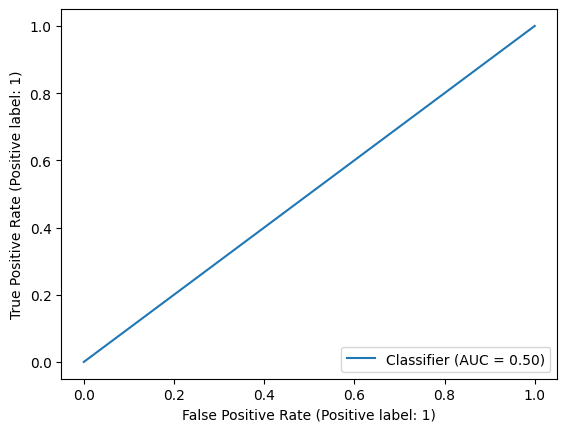

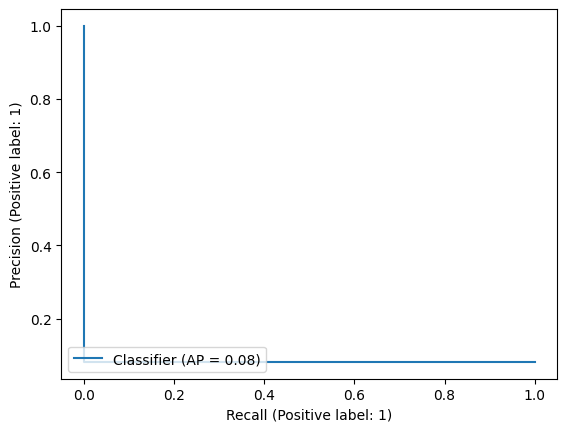

In [24]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

RocCurveDisplay.from_predictions(y1_test, y_pred)
PrecisionRecallDisplay.from_predictions(y1_test, y_pred)

3) Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

# Définition des paramètres de recherche
param_grid = {
        "C": np.logspace(-5, 1, 10),
        "l1_ratio": np.linspace(0, 1, 10),
        "class_weight": [None, "balanced"],
    }

# Sélection de la métrique de score
score = 'accuracy'

# Définition de HalvingRandomSearchCV avec StratifiedKFold
clf = HalvingRandomSearchCV(
    estimator=LogisticRegression(random_state=3),
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=score,
    verbose=1,
    random_state=3,
    n_jobs=-1,
)

# On crée l'objet pour imputer les valeurs manquantes de X1_train_scaled et X1_test_scale
# Car le modele RidgeClassifier n'accepte pas de NaN
imputer = SimpleImputer(strategy='median')

# On fit l'imputer sur notre jeu d'entrainement
imputer.fit(X1_train_scaled)

# On remplace les NaN
X1_train_scaled = imputer.transform(X1_train_scaled)
X1_test_scaled = imputer.transform(X1_test_scaled)

# Entraînement du modèle
clf.fit(X1_train_scaled, y1_train)

# Prédiction sur l'ensemble de test
y_pred = clf.predict(X1_test_scaled)
#y_pred_proba = my_ridge.predict_proba(X1_test_scaled)

# Résultats de l'évaluation du modèle
clf_results = {
    'Modele': 'LogisticRegression',
    "Parametres": clf.best_params_,
    "Score": clf.best_score_,
    "Cv_results_": clf.cv_results_,
    "Best_index_": clf.best_index_,
    "Confusion_matrix": confusion_matrix(y1_test, y_pred),
    "F1-score": f1_score(y1_test, y_pred),
    "Accuracy": accuracy_score(y1_test, y_pred),
    "Precision": precision_score(y1_test, y_pred),
    "Recall": recall_score(y1_test, y_pred),
    "Average_precision": average_precision_score(y1_test, y_pred),
    "Precision_recall_curve": precision_recall_curve(y1_test, y_pred),
    "Roc_auc_score": roc_auc_score(y1_test, y_pred),
    "Roc_curve": roc_curve(y1_test, y_pred),
}

print(clf_results)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 9
min_resources_: 20
max_resources_: 239711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 200
n_resources: 20
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

  warnings.warn(some_fits_failed_message, FitFailedWarning)


----------
iter: 1
n_candidates: 67
n_resources: 60
Fitting 5 folds for each of 67 candidates, totalling 335 fits
----------
iter: 2
n_candidates: 23
n_resources: 180
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 3
n_candidates: 8
n_resources: 540
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 1620
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'Modele': 'LogisticRegression', 'Parametres': {'l1_ratio': 0.8888888888888888, 'class_weight': None, 'C': 0.001}, 'Score': 0.9152276115124411, 'Cv_results_': {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 

In [26]:
new_row_df = pd.DataFrame([clf_results])
modeles = pd.concat([modeles, new_row_df], ignore_index=True)
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
1,LogisticRegression,"{'l1_ratio': 0.8888888888888888, 'class_weight...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",298,"[[55015, 25], [4856, 32]]",0.012942,0.918552,0.561404,0.006547,0.084706,"([0.0815645441196102, 0.5614035087719298, 1.0]...",0.503046,"([0.0, 0.00045421511627906976, 1.0], [0.0, 0.0..."


4) SVM

In [28]:
from sklearn.svm import LinearSVC

# Définition des paramètres de recherche
param_grid = {
        "C": np.logspace(-5, 1, 10),
        "penalty": ["l1", "l2"],
        "fit_intercept": [True, False],
        "class_weight": [None, "balanced"],
}

# Sélection de la métrique de score
score = 'accuracy'

# Définition de HalvingRandomSearchCV avec StratifiedKFold
my_linear_svc = HalvingRandomSearchCV(
    estimator=LinearSVC(random_state=3),
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=score,
    verbose=1,
    random_state=3,
    n_jobs=-1,
)

# On crée l'objet pour imputer les valeurs manquantes de X1_train_scaled et X1_test_scale
# Car le modele RidgeClassifier n'accepte pas de NaN
imputer = SimpleImputer(strategy='median')

# On fit l'imputer sur notre jeu d'entrainement
imputer.fit(X1_train_scaled)

# On remplace les NaN
X1_train_scaled = imputer.transform(X1_train_scaled)
X1_test_scaled = imputer.transform(X1_test_scaled)

# Entraînement du modèle
my_linear_svc.fit(X1_train_scaled, y1_train)

# Prédiction sur l'ensemble de test
y_pred = my_linear_svc.predict(X1_test_scaled)
#y_pred_proba = my_ridge.predict_proba(X1_test_scaled)

# Résultats de l'évaluation du modèle
my_linear_svc_results = {
    'Modele': 'LinearSVC',
    "Parametres": my_linear_svc.best_params_,
    "Score": my_linear_svc.best_score_,
    "Cv_results_": my_linear_svc.cv_results_,
    "Best_index_": my_linear_svc.best_index_,
    "Confusion_matrix": confusion_matrix(y1_test, y_pred),
    "F1-score": f1_score(y1_test, y_pred),
    "Accuracy": accuracy_score(y1_test, y_pred),
    "Precision": precision_score(y1_test, y_pred),
    "Recall": recall_score(y1_test, y_pred),
    "Average_precision": average_precision_score(y1_test, y_pred),
    "Precision_recall_curve": precision_recall_curve(y1_test, y_pred),
    "Roc_auc_score": roc_auc_score(y1_test, y_pred),
    "Roc_curve": roc_curve(y1_test, y_pred),
}



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 9
min_resources_: 20
max_resources_: 239711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 20
Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penal

----------
iter: 1
n_candidates: 27
n_resources: 60
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty

----------
iter: 2
n_candidates: 9
n_resources: 180
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 3
n_resources: 540
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'Modele': 'LogisticRegression', 'Parametres': {'l1_ratio': 0.8888888888888888, 'class_weight': None, 'C': 0.001}, 'Score': 0.9152276115124411, 'Cv_results_': {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0,

In [29]:
print(my_linear_svc_results)

{'Modele': 'LinearSVC', 'Parametres': {'penalty': 'l2', 'fit_intercept': True, 'class_weight': None, 'C': 0.004641588833612777}, 'Score': 0.8881619937694705, 'Cv_results_': {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3]), 'n_resources': array([ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20, 

In [30]:
new_row_df = pd.DataFrame([my_linear_svc_results])
modeles = pd.concat([modeles, new_row_df], ignore_index=True)
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
1,LogisticRegression,"{'l1_ratio': 0.8888888888888888, 'class_weight...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",298,"[[55015, 25], [4856, 32]]",0.012942,0.918552,0.561404,0.006547,0.084706,"([0.0815645441196102, 0.5614035087719298, 1.0]...",0.503046,"([0.0, 0.00045421511627906976, 1.0], [0.0, 0.0..."
2,LinearSVC,"{'penalty': 'l2', 'fit_intercept': True, 'clas...",0.888162,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",118,"[[55033, 7], [4883, 5]]",0.002041,0.918402,0.416667,0.001023,0.081907,"([0.0815645441196102, 0.4166666666666667, 1.0]...",0.500448,"([0.0, 0.00012718023255813953, 1.0], [0.0, 0.0..."


In [31]:
from sklearn.tree import DecisionTreeClassifier

# Définition des paramètres de recherche
param_grid = {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_depth": [None] + list(range(2, 20, 3)),
        "max_features": [None, "auto", "sqrt", "log2"],
        "class_weight": [None, "balanced"],
    }

# Sélection de la métrique de score
score = 'accuracy'

# Définition de HalvingRandomSearchCV avec StratifiedKFold
estimator = HalvingRandomSearchCV(
    estimator=DecisionTreeClassifier(random_state=3),
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=score,
    verbose=1,
    random_state=3,
    n_jobs=-1,
)
# Entraînement du modèle
estimator.fit(X1_train_scaled, y1_train)

# Prédiction sur l'ensemble de test
y_pred = estimator.predict(X1_test_scaled)
#y_pred_proba = my_ridge.predict_proba(X1_test_scaled)

# Résultats de l'évaluation du modèle
estimator_results = {
    'Modele': 'LinearSVC',
    "Parametres": estimator.best_params_,
    "Score": estimator.best_score_,
    "Cv_results_": estimator.cv_results_,
    "Best_index_": estimator.best_index_,
    "Confusion_matrix": confusion_matrix(y1_test, y_pred),
    "F1-score": f1_score(y1_test, y_pred),
    "Accuracy": accuracy_score(y1_test, y_pred),
    "Precision": precision_score(y1_test, y_pred),
    "Recall": recall_score(y1_test, y_pred),
    "Average_precision": average_precision_score(y1_test, y_pred),
    "Precision_recall_curve": precision_recall_curve(y1_test, y_pred),
    "Roc_auc_score": roc_auc_score(y1_test, y_pred),
    "Roc_curve": roc_curve(y1_test, y_pred),
}
print(estimator_results)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 9
min_resources_: 20
max_resources_: 239711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 224
n_resources: 20
Fitting 5 folds for each of 224 candidates, totalling 1120 fits
----------
iter: 1
n_candidates: 75
n_resources: 60
Fitting 5 folds for each of 75 candidates, totalling 375 fits
----------
iter: 2
n_candidates: 25
n_resources: 180
Fitting 5 folds for each of 25 candidates, totalling 125 fits
----------
iter: 3
n_candidates: 9
n_resources: 540
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 4
n_candidates: 3
n_resources: 1620
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'Modele': 'LinearSVC', 'Parametres': {'splitter': 'best', 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'entropy', 'class_weight': None}, 'Score': 0.9152276115124411, 'Cv_results_': {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0,

In [32]:
new_row_df = pd.DataFrame([estimator_results])
modeles = pd.concat([modeles, new_row_df], ignore_index=True)
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
1,LogisticRegression,"{'l1_ratio': 0.8888888888888888, 'class_weight...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",298,"[[55015, 25], [4856, 32]]",0.012942,0.918552,0.561404,0.006547,0.084706,"([0.0815645441196102, 0.5614035087719298, 1.0]...",0.503046,"([0.0, 0.00045421511627906976, 1.0], [0.0, 0.0..."
2,LinearSVC,"{'penalty': 'l2', 'fit_intercept': True, 'clas...",0.888162,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",118,"[[55033, 7], [4883, 5]]",0.002041,0.918402,0.416667,0.001023,0.081907,"([0.0815645441196102, 0.4166666666666667, 1.0]...",0.500448,"([0.0, 0.00012718023255813953, 1.0], [0.0, 0.0..."
3,LinearSVC,"{'splitter': 'best', 'max_features': 'sqrt', '...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",333,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"


In [33]:
modeles.iloc[-1,0]= 'DecisionTreeClassifier'
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
1,LogisticRegression,"{'l1_ratio': 0.8888888888888888, 'class_weight...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",298,"[[55015, 25], [4856, 32]]",0.012942,0.918552,0.561404,0.006547,0.084706,"([0.0815645441196102, 0.5614035087719298, 1.0]...",0.503046,"([0.0, 0.00045421511627906976, 1.0], [0.0, 0.0..."
2,LinearSVC,"{'penalty': 'l2', 'fit_intercept': True, 'clas...",0.888162,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",118,"[[55033, 7], [4883, 5]]",0.002041,0.918402,0.416667,0.001023,0.081907,"([0.0815645441196102, 0.4166666666666667, 1.0]...",0.500448,"([0.0, 0.00012718023255813953, 1.0], [0.0, 0.0..."
3,DecisionTreeClassifier,"{'splitter': 'best', 'max_features': 'sqrt', '...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",333,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"


In [39]:
from sklearn.neighbors import KNeighborsClassifier

param_grid={
        "n_neighbors": range(2, 12, 2),
        "weights": ["uniform", "distance"],
    }
# Sélection de la métrique de score
score = 'accuracy'

# Définition de HalvingRandomSearchCV avec StratifiedKFold
estimator = HalvingRandomSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=score,
    verbose=1,
    random_state=3,
    n_jobs=-1,
)

# Entraînement du modèle
estimator.fit(X1_train_scaled, y1_train)

# Prédiction sur l'ensemble de test
y_pred = estimator.predict(X1_test_scaled)
#y_pred_proba = my_ridge.predict_proba(X1_test_scaled)

# Résultats de l'évaluation du modèle
estimator_results = {
    'Modele': 'KNeighborsClassifier',
    "Parametres": estimator.best_params_,
    "Score": estimator.best_score_,
    "Cv_results_": estimator.cv_results_,
    "Best_index_": estimator.best_index_,
    "Confusion_matrix": confusion_matrix(y1_test, y_pred),
    "F1-score": f1_score(y1_test, y_pred),
    "Accuracy": accuracy_score(y1_test, y_pred),
    "Precision": precision_score(y1_test, y_pred),
    "Recall": recall_score(y1_test, y_pred),
    "Average_precision": average_precision_score(y1_test, y_pred),
    "Precision_recall_curve": precision_recall_curve(y1_test, y_pred),
    "Roc_auc_score": roc_auc_score(y1_test, y_pred),
    "Roc_curve": roc_curve(y1_test, y_pred),
}
print(estimator_results)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 9
min_resources_: 20
max_resources_: 239711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'Modele': 'KNeighborsClassifier', 'Parametres': {'weights': 'uniform', 'n_neighbors': 10}, 'Score': 0.9547619047619047, 'Cv_results_': {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2]), 'n_resources': array([ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  60,  60,  60,
        60, 180, 180]), 'mean_fit_time': array([0.08470726, 0.04269443, 0.03410811, 0.05369229, 0.04596615,
       0.03871775, 0.04921961, 0.03162322, 0.03665509, 0.03464203,
       0.05292835, 0.02314634, 0.04456077, 0.0605153

In [40]:
new_row_df = pd.DataFrame([estimator_results])
modeles = pd.concat([modeles, new_row_df], ignore_index=True)
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
1,LogisticRegression,"{'l1_ratio': 0.8888888888888888, 'class_weight...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",298,"[[55015, 25], [4856, 32]]",0.012942,0.918552,0.561404,0.006547,0.084706,"([0.0815645441196102, 0.5614035087719298, 1.0]...",0.503046,"([0.0, 0.00045421511627906976, 1.0], [0.0, 0.0..."
2,LinearSVC,"{'penalty': 'l2', 'fit_intercept': True, 'clas...",0.888162,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",118,"[[55033, 7], [4883, 5]]",0.002041,0.918402,0.416667,0.001023,0.081907,"([0.0815645441196102, 0.4166666666666667, 1.0]...",0.500448,"([0.0, 0.00012718023255813953, 1.0], [0.0, 0.0..."
3,DecisionTreeClassifier,"{'splitter': 'best', 'max_features': 'sqrt', '...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",333,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
4,KNeighborsClassifier,"{'weights': 'uniform', 'n_neighbors': 10}",0.954762,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",14,"[[54988, 52], [4866, 22]]",0.008867,0.917935,0.297297,0.004501,0.082536,"([0.0815645441196102, 0.2972972972972973, 1.0]...",0.501778,"([0.0, 0.0009447674418604651, 1.0], [0.0, 0.00..."


In [41]:
from sklearn.svm import SVC

param_grid={
        "C": np.logspace(-5, 1, 10),
        "gamma": ["scale", "auto"],
        "kernel": ["linear", "poly", "rbf"],
        "class_weight": [None, "balanced"],
    }
# Sélection de la métrique de score
score = 'accuracy'

# Définition de HalvingRandomSearchCV avec StratifiedKFold
estimator = HalvingRandomSearchCV(
    estimator=SVC(),
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=score,
    verbose=1,
    random_state=3,
    n_jobs=-1,
)

# Entraînement du modèle
estimator.fit(X1_train_scaled, y1_train)

# Prédiction sur l'ensemble de test
y_pred = estimator.predict(X1_test_scaled)
#y_pred_proba = my_ridge.predict_proba(X1_test_scaled)

# Résultats de l'évaluation du modèle
estimator_results = {
    'Modele': 'SVC',
    "Parametres": estimator.best_params_,
    "Score": estimator.best_score_,
    "Cv_results_": estimator.cv_results_,
    "Best_index_": estimator.best_index_,
    "Confusion_matrix": confusion_matrix(y1_test, y_pred),
    "F1-score": f1_score(y1_test, y_pred),
    "Accuracy": accuracy_score(y1_test, y_pred),
    "Precision": precision_score(y1_test, y_pred),
    "Recall": recall_score(y1_test, y_pred),
    "Average_precision": average_precision_score(y1_test, y_pred),
    "Precision_recall_curve": precision_recall_curve(y1_test, y_pred),
    "Roc_auc_score": roc_auc_score(y1_test, y_pred),
    "Roc_curve": roc_curve(y1_test, y_pred),
}
print(estimator_results)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 9
min_resources_: 20
max_resources_: 239711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 360
n_resources: 20
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 201, in fit
    y = self._validate_targets(y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 749, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 

----------
iter: 1
n_candidates: 120
n_resources: 60
Fitting 5 folds for each of 120 candidates, totalling 600 fits
----------
iter: 2
n_candidates: 40
n_resources: 180
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 3
n_candidates: 14
n_resources: 540
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 4
n_candidates: 5
n_resources: 1620
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 5
n_candidates: 2
n_resources: 4860
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'Modele': 'SVC', 'Parametres': {'kernel': 'linear', 'gamma': 'auto', 'degree': 2, 'class_weight': None, 'C': 1e-05}, 'Score': 0.918246642339788, 'Cv_results_': {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [42]:
new_row_df = pd.DataFrame([estimator_results])
modeles = pd.concat([modeles, new_row_df], ignore_index=True)
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
1,LogisticRegression,"{'l1_ratio': 0.8888888888888888, 'class_weight...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",298,"[[55015, 25], [4856, 32]]",0.012942,0.918552,0.561404,0.006547,0.084706,"([0.0815645441196102, 0.5614035087719298, 1.0]...",0.503046,"([0.0, 0.00045421511627906976, 1.0], [0.0, 0.0..."
2,LinearSVC,"{'penalty': 'l2', 'fit_intercept': True, 'clas...",0.888162,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",118,"[[55033, 7], [4883, 5]]",0.002041,0.918402,0.416667,0.001023,0.081907,"([0.0815645441196102, 0.4166666666666667, 1.0]...",0.500448,"([0.0, 0.00012718023255813953, 1.0], [0.0, 0.0..."
3,DecisionTreeClassifier,"{'splitter': 'best', 'max_features': 'sqrt', '...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",333,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
4,KNeighborsClassifier,"{'weights': 'uniform', 'n_neighbors': 10}",0.954762,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",14,"[[54988, 52], [4866, 22]]",0.008867,0.917935,0.297297,0.004501,0.082536,"([0.0815645441196102, 0.2972972972972973, 1.0]...",0.501778,"([0.0, 0.0009447674418604651, 1.0], [0.0, 0.00..."
5,SVC,"{'kernel': 'linear', 'gamma': 'auto', 'degree'...",0.918247,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",540,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"


In [44]:
from sklearn.ensemble import BaggingClassifier

param_grid={
        "base_estimator": [DecisionTreeClassifier()]
        + [DecisionTreeClassifier(max_depth=x) for x in range(2, 20, 3)],
        "n_estimators": np.logspace(1, 3, 20).astype(int),
        "n_jobs": [-1]
    }
# Sélection de la métrique de score
score = 'accuracy'

# Définition de HalvingRandomSearchCV avec StratifiedKFold
estimator = HalvingRandomSearchCV(
    estimator=BaggingClassifier(random_state=3),
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=score,
    verbose=1,
    random_state=3,
    n_jobs=-1,
)

# Entraînement du modèle
estimator.fit(X1_train_scaled, y1_train)

# Prédiction sur l'ensemble de test
y_pred = estimator.predict(X1_test_scaled)
#y_pred_proba = my_ridge.predict_proba(X1_test_scaled)

# Résultats de l'évaluation du modèle
estimator_results = {
    'Modele': 'SVC',
    "Parametres": estimator.best_params_,
    "Score": estimator.best_score_,
    "Cv_results_": estimator.cv_results_,
    "Best_index_": estimator.best_index_,
    "Confusion_matrix": confusion_matrix(y1_test, y_pred),
    "F1-score": f1_score(y1_test, y_pred),
    "Accuracy": accuracy_score(y1_test, y_pred),
    "Precision": precision_score(y1_test, y_pred),
    "Recall": recall_score(y1_test, y_pred),
    "Average_precision": average_precision_score(y1_test, y_pred),
    "Precision_recall_curve": precision_recall_curve(y1_test, y_pred),
    "Roc_auc_score": roc_auc_score(y1_test, y_pred),
    "Roc_curve": roc_curve(y1_test, y_pred),
}
print(estimator_results)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 9
min_resources_: 20
max_resources_: 239711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 140
n_resources: 20
Fitting 5 folds for each of 140 candidates, totalling 700 fits
----------
iter: 1
n_candidates: 47
n_resources: 60
Fitting 5 folds for each of 47 candidates, totalling 235 fits
----------
iter: 2
n_candidates: 16
n_resources: 180
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 3
n_candidates: 6
n_resources: 540
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'Modele': 'SVC', 'Parametres': {'n_jobs': -1, 'n_estimators': 379, 'base_estimator': DecisionTreeClassifier(max_depth=2)}, 'Score': 0.9146084164660016, 'Cv_results_': {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4]), 'n_resources': array([  20,   20,   20,   20,   20,   20,   20,   20,   20,   20,   20,
         20,   20,   20,   20,

In [45]:
estimator_results['Modele'] = 'BaggingClassifier'

In [46]:
new_row_df = pd.DataFrame([estimator_results])
modeles = pd.concat([modeles, new_row_df], ignore_index=True)
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
1,LogisticRegression,"{'l1_ratio': 0.8888888888888888, 'class_weight...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",298,"[[55015, 25], [4856, 32]]",0.012942,0.918552,0.561404,0.006547,0.084706,"([0.0815645441196102, 0.5614035087719298, 1.0]...",0.503046,"([0.0, 0.00045421511627906976, 1.0], [0.0, 0.0..."
2,LinearSVC,"{'penalty': 'l2', 'fit_intercept': True, 'clas...",0.888162,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",118,"[[55033, 7], [4883, 5]]",0.002041,0.918402,0.416667,0.001023,0.081907,"([0.0815645441196102, 0.4166666666666667, 1.0]...",0.500448,"([0.0, 0.00012718023255813953, 1.0], [0.0, 0.0..."
3,DecisionTreeClassifier,"{'splitter': 'best', 'max_features': 'sqrt', '...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",333,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
4,KNeighborsClassifier,"{'weights': 'uniform', 'n_neighbors': 10}",0.954762,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",14,"[[54988, 52], [4866, 22]]",0.008867,0.917935,0.297297,0.004501,0.082536,"([0.0815645441196102, 0.2972972972972973, 1.0]...",0.501778,"([0.0, 0.0009447674418604651, 1.0], [0.0, 0.00..."
5,SVC,"{'kernel': 'linear', 'gamma': 'auto', 'degree'...",0.918247,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",540,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
6,BaggingClassifier,"{'n_jobs': -1, 'n_estimators': 379, 'base_esti...",0.914608,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",209,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"


In [48]:
from sklearn.ensemble import RandomForestClassifier

param_grid={
        "n_estimators": np.logspace(1, 3, 3).astype(int),
        "max_depth": list(range(2, 20, 3)),
        "max_features": ["auto", "sqrt", "log2"],
        "class_weight": ["balanced_subsample", "balanced"],
    }
# Sélection de la métrique de score
score = 'accuracy'

# Définition de HalvingRandomSearchCV avec StratifiedKFold
estimator = HalvingRandomSearchCV(
    estimator=RandomForestClassifier(random_state=3),
    param_distributions=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=3),
    scoring=score,
    verbose=1,
    random_state=3,
    n_jobs=-1,
)

# Entraînement du modèle
estimator.fit(X1_train_scaled, y1_train)

# Prédiction sur l'ensemble de test
y_pred = estimator.predict(X1_test_scaled)
#y_pred_proba = my_ridge.predict_proba(X1_test_scaled)

# Résultats de l'évaluation du modèle
estimator_results = {
    'Modele': 'RandomForestClassifier',
    "Parametres": estimator.best_params_,
    "Score": estimator.best_score_,
    "Cv_results_": estimator.cv_results_,
    "Best_index_": estimator.best_index_,
    "Confusion_matrix": confusion_matrix(y1_test, y_pred),
    "F1-score": f1_score(y1_test, y_pred),
    "Accuracy": accuracy_score(y1_test, y_pred),
    "Precision": precision_score(y1_test, y_pred),
    "Recall": recall_score(y1_test, y_pred),
    "Average_precision": average_precision_score(y1_test, y_pred),
    "Precision_recall_curve": precision_recall_curve(y1_test, y_pred),
    "Roc_auc_score": roc_auc_score(y1_test, y_pred),
    "Roc_curve": roc_curve(y1_test, y_pred),
}
print(estimator_results)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 9
min_resources_: 20
max_resources_: 239711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 20
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 1
n_candidates: 36
n_resources: 60
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 12
n_resources: 180
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 540
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'Modele': 'RandomForestClassifier', 'Parametres': {'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 5, 'class_weight': 'balanced_subsample'}, 'Score': 0.8477735733669686, 'Cv_results_': {'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    

In [52]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
print(classification_report(y1_test, y_pred))
display(pd.DataFrame(confusion_matrix(y1_test, y_pred)))
print(roc_auc_score(y1_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     55040
           1       0.15      0.65      0.25      4888

    accuracy                           0.68     59928
   macro avg       0.56      0.67      0.52     59928
weighted avg       0.89      0.68      0.75     59928



,0,1
0,37692,17348
1,1713,3175


0.6671804823392836


In [49]:
new_row_df = pd.DataFrame([estimator_results])
modeles = pd.concat([modeles, new_row_df], ignore_index=True)
modeles

,Modele,Parametres,Score,Cv_results_,Best_index_,Confusion_matrix,F1-score,Accuracy,Precision,Recall,Average_precision,Precision_recall_curve,Roc_auc_score,Roc_curve
0,Ridge,"{'solver': 'saga', 'fit_intercept': True, 'cla...",0.918496,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2099,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
1,LogisticRegression,"{'l1_ratio': 0.8888888888888888, 'class_weight...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",298,"[[55015, 25], [4856, 32]]",0.012942,0.918552,0.561404,0.006547,0.084706,"([0.0815645441196102, 0.5614035087719298, 1.0]...",0.503046,"([0.0, 0.00045421511627906976, 1.0], [0.0, 0.0..."
2,LinearSVC,"{'penalty': 'l2', 'fit_intercept': True, 'clas...",0.888162,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",118,"[[55033, 7], [4883, 5]]",0.002041,0.918402,0.416667,0.001023,0.081907,"([0.0815645441196102, 0.4166666666666667, 1.0]...",0.500448,"([0.0, 0.00012718023255813953, 1.0], [0.0, 0.0..."
3,DecisionTreeClassifier,"{'splitter': 'best', 'max_features': 'sqrt', '...",0.915228,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",333,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
4,KNeighborsClassifier,"{'weights': 'uniform', 'n_neighbors': 10}",0.954762,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",14,"[[54988, 52], [4866, 22]]",0.008867,0.917935,0.297297,0.004501,0.082536,"([0.0815645441196102, 0.2972972972972973, 1.0]...",0.501778,"([0.0, 0.0009447674418604651, 1.0], [0.0, 0.00..."
5,SVC,"{'kernel': 'linear', 'gamma': 'auto', 'degree'...",0.918247,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",540,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
6,BaggingClassifier,"{'n_jobs': -1, 'n_estimators': 379, 'base_esti...",0.914608,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",209,"[[55040, 0], [4888, 0]]",0.000000,0.918435,0.000000,0.000000,0.081565,"([0.0815645441196102, 1.0], [1.0, 0.0], [0])",0.500000,"([0.0, 1.0], [0.0, 1.0], [1, 0])"
7,RandomForestClassifier,"{'n_estimators': 1000, 'max_features': 'sqrt',...",0.847774,"{'iter': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",160,"[[37692, 17348], [1713, 3175]]",0.249892,0.681935,0.154704,0.649550,0.129073,"([0.0815645441196102, 0.15470447790284073, 1.0...",0.667180,"([0.0, 0.3151889534883721, 1.0], [0.0, 0.64954..."


In [ ]:
print(modeles.shape[0]-1])

(array([0., 1.]), array([0., 1.]), array([1, 0]))


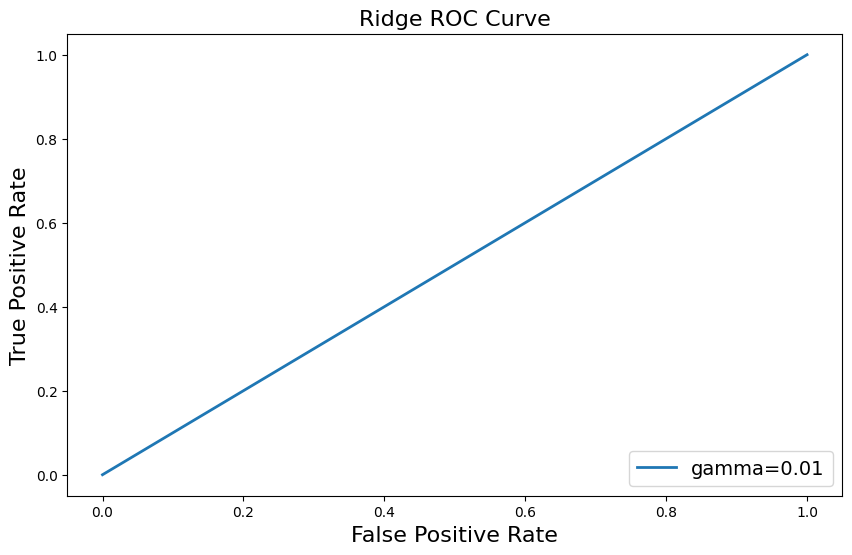

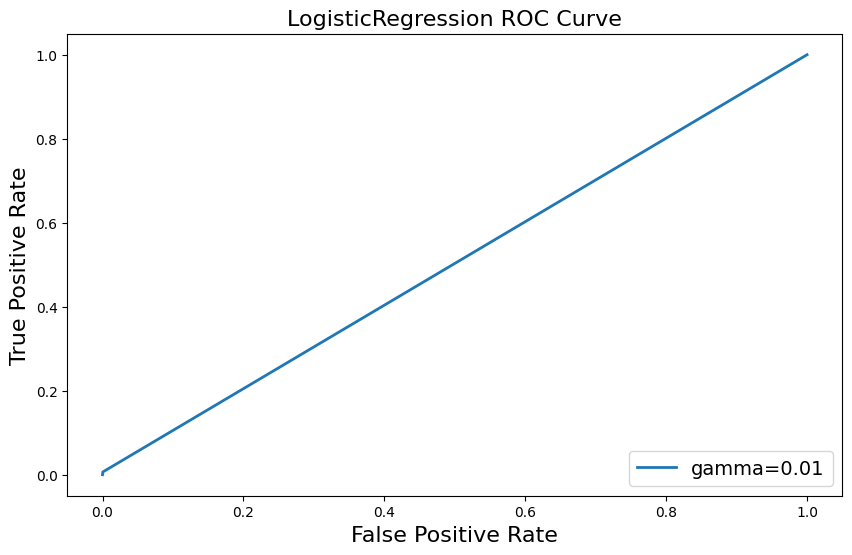

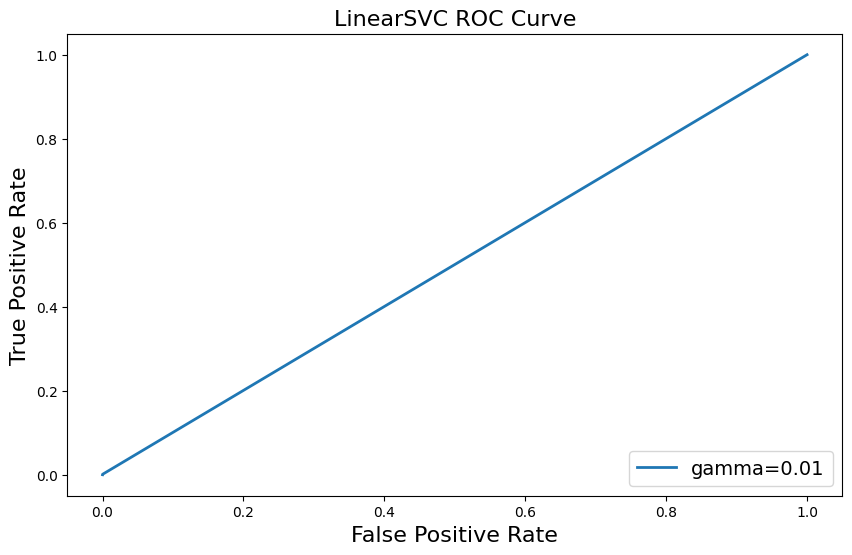

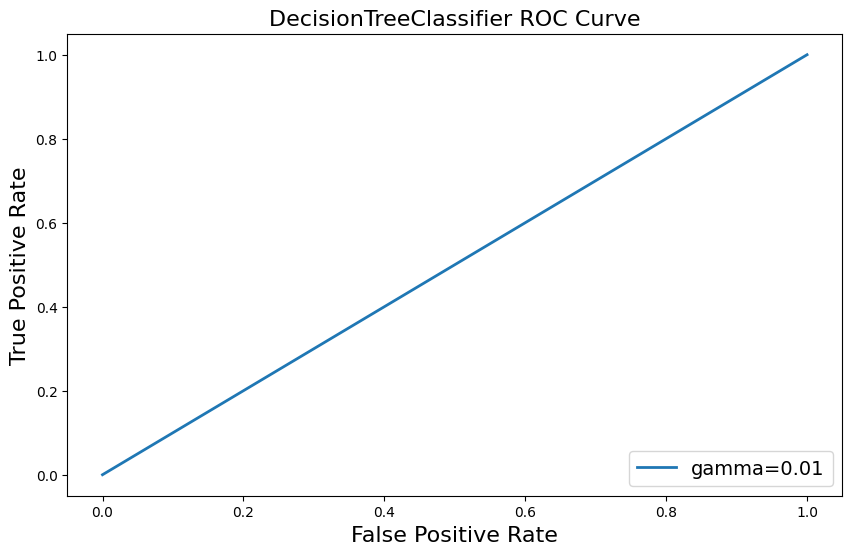

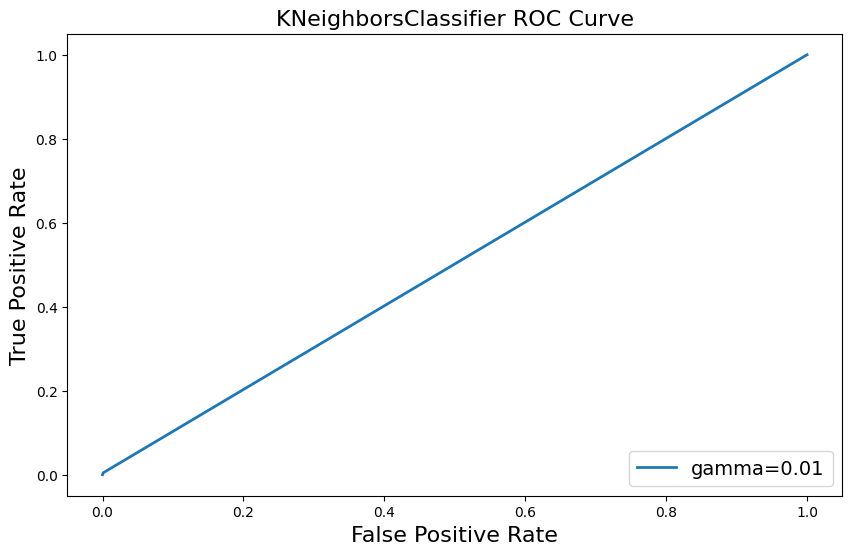

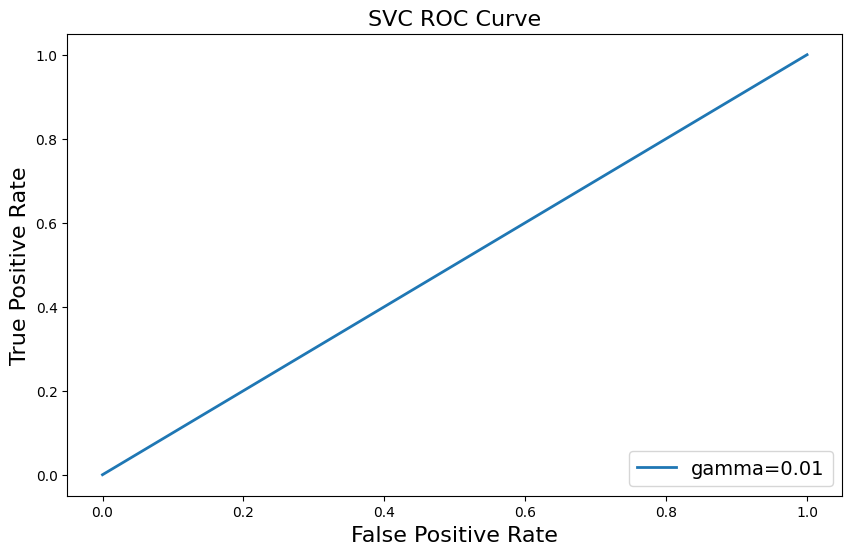

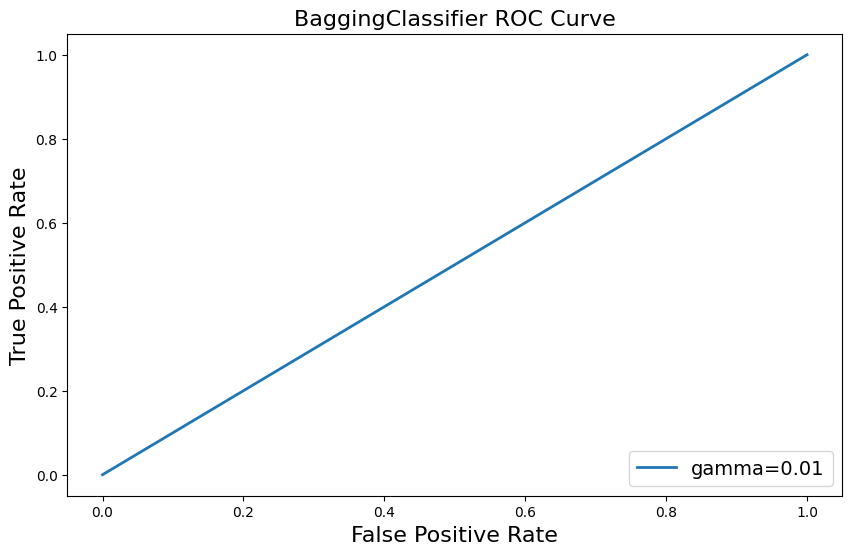

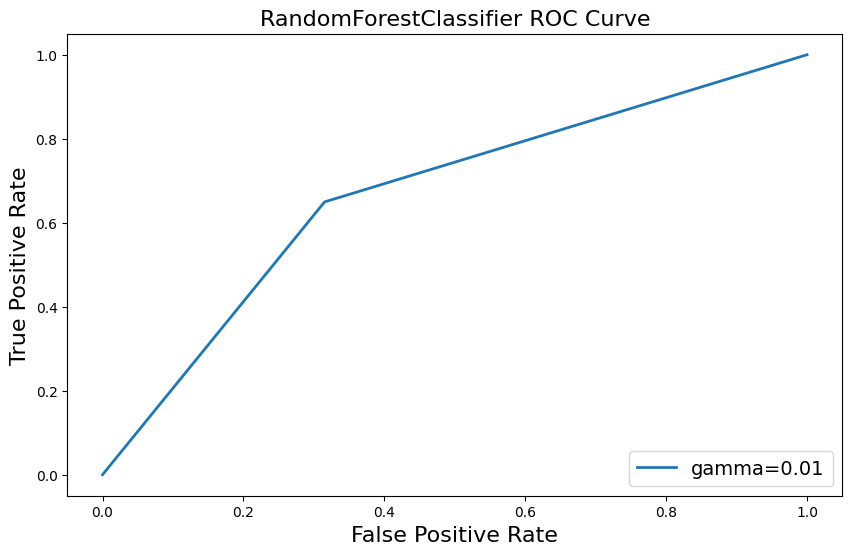

IndexError: index 8 is out of bounds for axis 0 with size 8

<Figure size 1000x600 with 0 Axes>

In [ ]:
for i in range(modeles.shape[1]):
    plt.figure(figsize=(10, 6))
    roc_curve = modeles.iloc[i,modeles.shape[0]-1]
    fpr = roc_curve[0]
    tpr = roc_curve[1]
    #auc = roc_auc_score(fpr, tpr)
    plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01')# AUC=%.2f' % auc)

    # donner un titre aux axes et au graphique
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(f'{modeles.loc[i,"Modele"]} ROC Curve', fontsize=16)

    # afficher la légende
    plt.legend(loc="lower right", fontsize=14)

    # afficher l'image
    plt.show()
